<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/skhabiri_LS_DS_build2_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
import pandas as pd
import numpy as np
!pip install category_encoders==2.*


data = pd.read_csv('https://github.com/skhabiri/Forest_cover_type_data/raw/master/train.csv')
print(data.shape)
data.head()


     |████████████████████████████████| 81kB 2.1MB/s 
(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [2]:
data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [3]:
data.nunique().sort_values(ascending=False)

Id                                    15120
Horizontal_Distance_To_Roadways        3250
Horizontal_Distance_To_Fire_Points     2710
Elevation                              1665
Vertical_Distance_To_Hydrology          423
Horizontal_Distance_To_Hydrology        400
Aspect                                  361
Hillshade_3pm                           247
Hillshade_9am                           176
Hillshade_Noon                          141
Slope                                    52
Cover_Type                                7
Soil_Type29                               2
Soil_Type28                               2
Soil_Type5                                2
Soil_Type4                                2
Soil_Type3                                2
Soil_Type2                                2
Soil_Type1                                2
Wilderness_Area4                          2
Wilderness_Area3                          2
Wilderness_Area2                          2
Wilderness_Area1                

In [4]:
data["Cover_Type"].value_counts(normalize=True)

7    0.142857
6    0.142857
5    0.142857
4    0.142857
3    0.142857
2    0.142857
1    0.142857
Name: Cover_Type, dtype: float64

In [5]:
# pd.Series({c: data[c].unique() for c in data})[-40:]
# [data[col].unique() for col in data]

In [6]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix


import random 
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Our target label is "Cover_Type"
We will drop imb% imbalance low cardinal features. We also drop "id" column.

In [7]:
def skew_col(X, imb=0.99):
  '''
  Returns the sorted list of feature names 
  with imbalance exceeding imb value
  '''
  X=X.copy()
  # drop the binary features with imb% imbalance
  # mask = X.nunique().sort_values(ascending=False) < 5
  # lowcard_col = X.nunique().sort_values(ascending=False)[mask].index

  mask2 = pd.Series({col: X[col].value_counts().
                     max()/X[col].value_counts().
                     sum() for col in X.nunique().index}).sort_values(ascending=False)
  
  mask2 = mask2[mask2 >= imb]

  Id_skew_cols = ["Id"] + list(mask2.index) 
  return Id_skew_cols

### Train Test split:
Target = "Cover_Type"

In [8]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(data, train_size=0.80, test_size=0.20, stratify=data["Cover_Type"], 
                                random_state=42)
print(f'train: {train.shape}, val: {val.shape}')


# Separate class label and data 
y_train = train["Cover_Type"]
X_train = train.drop("Cover_Type", axis=1)
y_val = val["Cover_Type"]
X_val = val.drop("Cover_Type", axis=1)

train: (12096, 56), val: (3024, 56)


In [9]:
Id_skew_cols = skew_col(X_train, imb=0.999)
Id_skew_cols

['Id',
 'Soil_Type15',
 'Soil_Type7',
 'Soil_Type25',
 'Soil_Type8',
 'Soil_Type28',
 'Soil_Type9',
 'Soil_Type36',
 'Soil_Type27']

In [10]:
def wrangle(X, cols, drop_count=1):
  '''
  drops drop_count number of features from cols starting from index=0 (Id)
  '''  
  # print("running transformer ....")
  X = X.copy()
  X = X.drop(labels=cols[:drop_count], axis=1)
  return X


### Baseline model

In [11]:
y_train.value_counts(normalize=True)

7    0.142857
6    0.142857
5    0.142857
4    0.142857
3    0.142857
2    0.142857
1    0.142857
Name: Cover_Type, dtype: float64

* Check for Nan value

In [12]:
X_train.isna().sum(axis=0).sum()

0

In [13]:
def clf_name(estimator, est_dict):
  return est_dict[estimator].__class__.__name__

### functions for pipeline fit, and metrics

In [14]:
def fit_rep(estimator, X_train, y_train, X_val, y_val, kwargs_dict):
  estimator.set_params(functiontransformer__kw_args = kwargs_dict)

  print("\n fitting ...")
  estimator.fit(X_train, y_train)

  print("\n getting X_train transformed column labels")
  feat_name = estimator.named_steps['functiontransformer'].transform(X_train).columns
  print("X_train cols:", len(X_train.columns), "X_fit cols:", len(feat_name))
  assert len(X_train.columns) == len(feat_name) + drop_count

  print("\n predicting ...")
  y_pred = estimator.predict(X_val)
  
  score_train = estimator.score(X_train, y_train)
  score_val = estimator.score(X_val, y_val)

  print("\n score ...")
  print('Training score', score_train)
  print('Validation score', score_val)

  accuracy_score_train = accuracy_score(y_train, estimator.predict(X_train))
  accuracy_score_val = accuracy_score(y_val, y_pred)

  print("\n Accuracy ...")
  print('Training Accuracy', accuracy_score_train)
  print('Validation Accuracy', accuracy_score_val)

  return estimator, y_pred, feat_name


In [15]:
def metric_rep(estimator, X_val, y_val):
  
  print("\n predicting y ...")
  y_pred = estimator.predict(X_val)
  
  print("\n plotting confusion matrix ...")
  plt.rcParams['figure.dpi'] = 100
  plot_confusion_matrix(estimator, X_val, y_val, values_format='.0f', xticks_rotation='vertical')
  
  print("\n calculating confusion matrix ...")
  C = pd.DataFrame(confusion_matrix(y_val, y_pred))
  print(C)
  truth_sum = C.sum(axis=1)
  predict_sum = C.sum(axis=0)
  pred_t = pd.Series([C.iloc[i,i] for i in range(len(C))])

  recall = pred_t / truth_sum
  precision = pred_t / predict_sum
  accuracy = pred_t.sum() / truth_sum.sum()

  print("\n classification report ...")
  print(classification_report(y_val, y_pred, target_names=estimator.classes_.astype(str)))

  print(f"******\n accuracy is {accuracy:.2f}\n******")

  return accuracy, precision, recall

In [16]:
drop_count = len(Id_skew_cols)
drop_cols = Id_skew_cols
kwargs_dict ={'drop_count': drop_count,
              'cols': drop_cols
              }

In [17]:
# LogisticRegression
lr = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    StandardScaler(),
    LogisticRegression(random_state=42)
    )

In [18]:
# LR.named_steps['functiontransformer']

In [19]:
# RidgeClassifier
rc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    StandardScaler(),
    RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, 
                    max_iter=None, tol=0.001, class_weight=None, solver='auto', 
                    random_state=42)
    )

In [20]:
# RandomForestClassifier
rfc = make_pipeline(
        FunctionTransformer(wrangle, validate=False), 
        # ce.OneHotEncoder(use_cat_names=True), 
        # SimpleImputer(strategy='median'), 
        RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
  ) 

In [21]:
# GradientBoostingClassifier
# It needs NaN to be dealth with
gbc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(), 
    # SimpleImputer(strategy='median'), 
    GradientBoostingClassifier()
)

In [22]:
# XGBoost
# It can handle NaNs
xgbc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
)

In [23]:
est_dict = {
    lr: LogisticRegression(),
    rc: RidgeClassifier(),
    rfc: RandomForestClassifier(),
    gbc: GradientBoostingClassifier(),
    xgbc: XGBClassifier()
            }

In [24]:
# est = [lr, rc, rfc, gbc, xgbc]
est = [xgbc]

empt_list = [np.NaN]*len(est)
feat_name = empt_list.copy()
y_pred = empt_list.copy()

for i, estimator in enumerate(est):
  print(f"********** {est_dict[estimator].__class__.__name__} **********")
  (est[i], y_pred[i], feat_name[i]) = fit_rep(estimator, X_train, y_train, X_val, y_val, kwargs_dict)


********** XGBClassifier **********

 fitting ...

 getting X_train transformed column labels
X_train cols: 55 X_fit cols: 46

 predicting ...

 score ...
Training score 0.7746362433862434
Validation score 0.7463624338624338

 Accuracy ...
Training Accuracy 0.7746362433862434
Validation Accuracy 0.7463624338624338


In [25]:
# gbc.named_steps['gradientboostingclassifier'].classes_

********** XGBClassifier **********

 predicting y ...

 plotting confusion matrix ...

 calculating confusion matrix ...
     0    1    2    3    4    5    6
0  294   55    1    0   20    2   60
1  105  201   10    0   89   23    4
2    0    0  254   40   21  117    0
3    0    0   19  406    0    7    0
4    0   15   15    0  389   13    0
5    0    0   96   15   15  306    0
6   25    0    0    0    0    0  407

 classification report ...
              precision    recall  f1-score   support

           1       0.69      0.68      0.69       432
           2       0.74      0.47      0.57       432
           3       0.64      0.59      0.61       432
           4       0.88      0.94      0.91       432
           5       0.73      0.90      0.81       432
           6       0.65      0.71      0.68       432
           7       0.86      0.94      0.90       432

    accuracy                           0.75      3024
   macro avg       0.74      0.75      0.74      3024
weighted avg

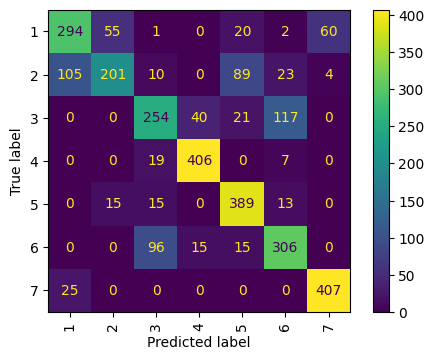

In [26]:
est2 = est.copy()
# est2 = [rfc]
empt_list = [np.NaN]*len(est2)
accuracy = empt_list[:]
precision = empt_list.copy()
recall = empt_list.copy()

for i, estimator in enumerate(est2):
  print(f"********** {est_dict[estimator].__class__.__name__} **********")
  (accuracy[i], precision[i], recall[i]) = metric_rep(estimator, X_val, y_val);

In [27]:
## tree depth analysis
# max_depth = list()
# for tree in clf.estimators_:
#     max_depth.append(tree.tree_.max_depth)

# print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))



### feature_importances and permutation_importance

In [28]:
selected_feat = feat_name[0]

In [29]:
# sklearn permutation_importances
from sklearn.inspection import permutation_importance
def important_features(estimator, est_dict, X_val, y_val, selected_feat, n_feat=25, n_repeats=5):
  '''
  n_feat: number of top features
  n_repeats: number of prmutations per column
  '''
  #permutation importance does not see function transformer and column reduction. Hence permutates over all X_val columns
  # permutation shuffles each column of X_val n_repeats time and take a mean
  result = permutation_importance(estimator, X_val, y_val, 
                                n_repeats=n_repeats, random_state=42)
  print(result.keys())
  df = pd.DataFrame({'feature': X_val.columns,
                   'importances_mean': np.round(result['importances_mean'], 4),
                   'importances_std': result['importances_std']
                   })

  # Selecting selected columns by estimator
  df = df[df.loc[:,"feature"].isin(selected_feat)]

  # feature_importance metric directly from the estimator
  df["feature_importance"] = estimator.named_steps[est_dict[estimator].__class__.__name__.lower()].feature_importances_

  # Sorting based on permutation importance values
  df = df.sort_values(by='importances_mean', ascending=False)
  df = df.rename(columns={'importances_mean': 'permutation_importance'})
  
  # Plotting top n features and comparing permutation vs. estimator feature important values.
  ax = df.iloc[:n_feat,:].plot(x="feature", y=["permutation_importance", "feature_importance"], 
                               kind='barh', figsize=(8,n_feat/2), 
                               title = f"top {n_feat} important features in {est_dict[estimator].__class__.__name__}")
  ax.invert_yaxis()
  ax.set_xlabel("importance value")
  plt.show()
  
  return df

********** XGBClassifier **********
dict_keys(['importances_mean', 'importances_std', 'importances'])


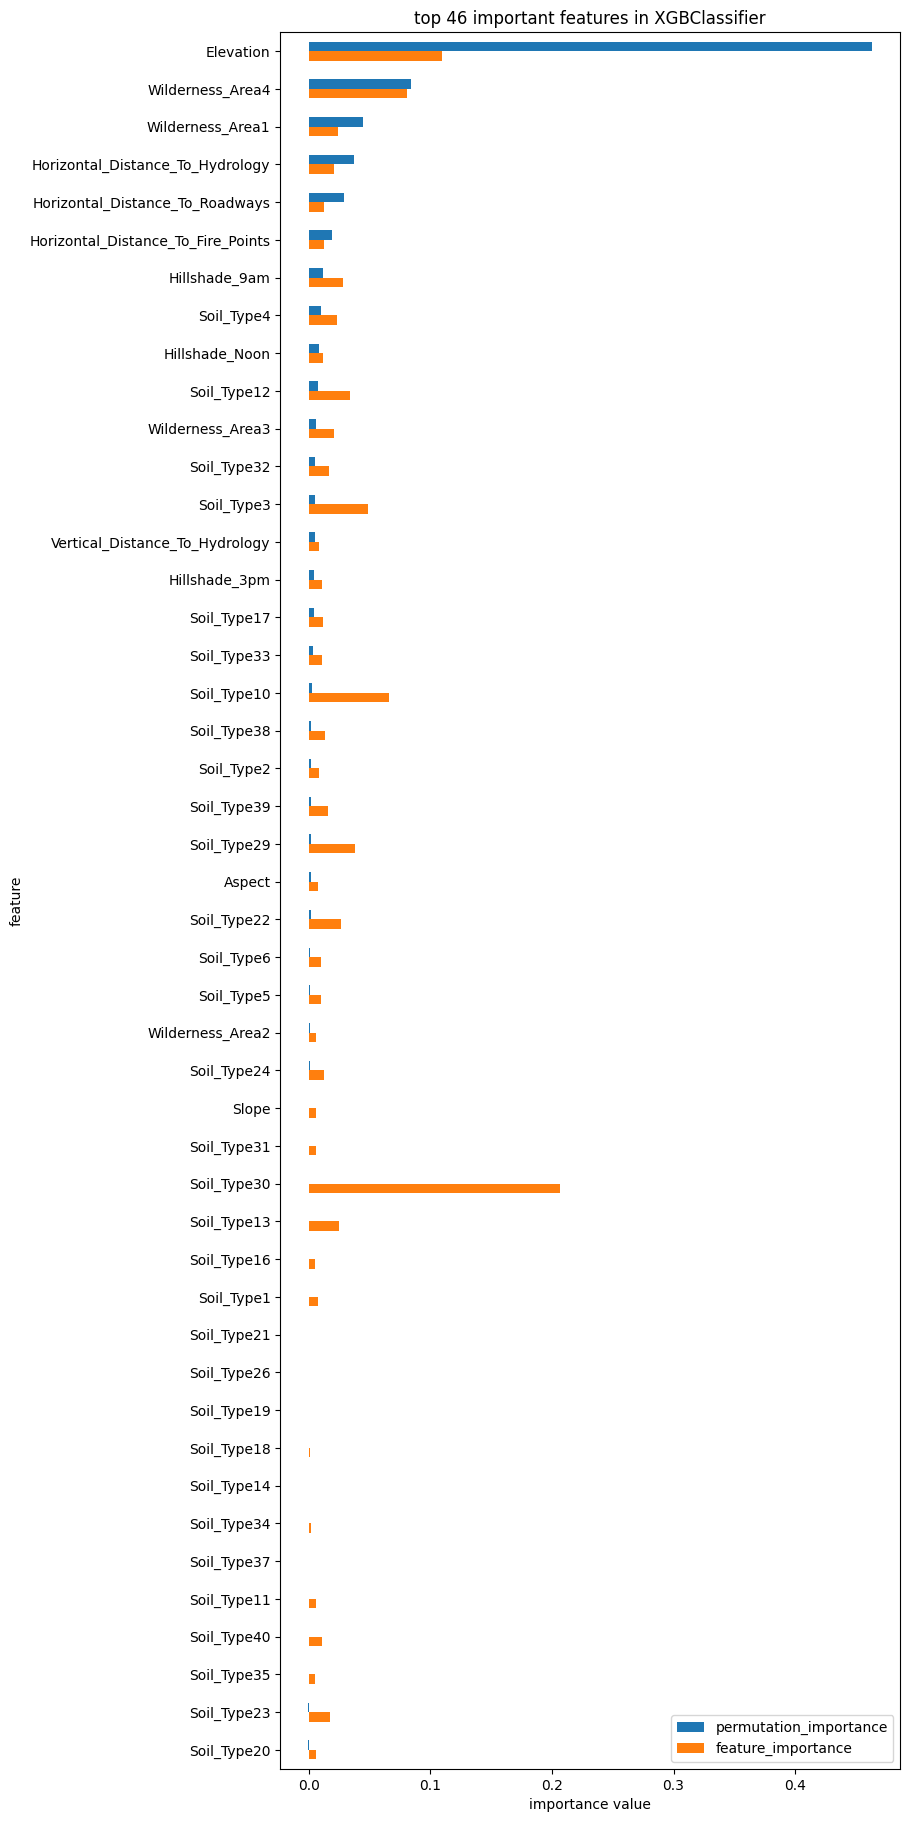

In [30]:
for i, estimator in enumerate(est2):
  print(f"********** {est_dict[estimator].__class__.__name__} **********")
  df_importance = important_features(estimator=estimator, est_dict=est_dict, X_val=X_val, y_val=y_val, selected_feat=selected_feat, n_feat=len(feat_name[0]), n_repeats=5)

In [31]:
len(feat_name[0])

46

In the presence of all the features, feature_importance_ of Id column ranks relatively high. Hence, feature_importance_ by itself cannot be a deciding factor. We drop 10% of skewed columns to get 82% accuracy

Text(0.5, 0, 'Importance value')

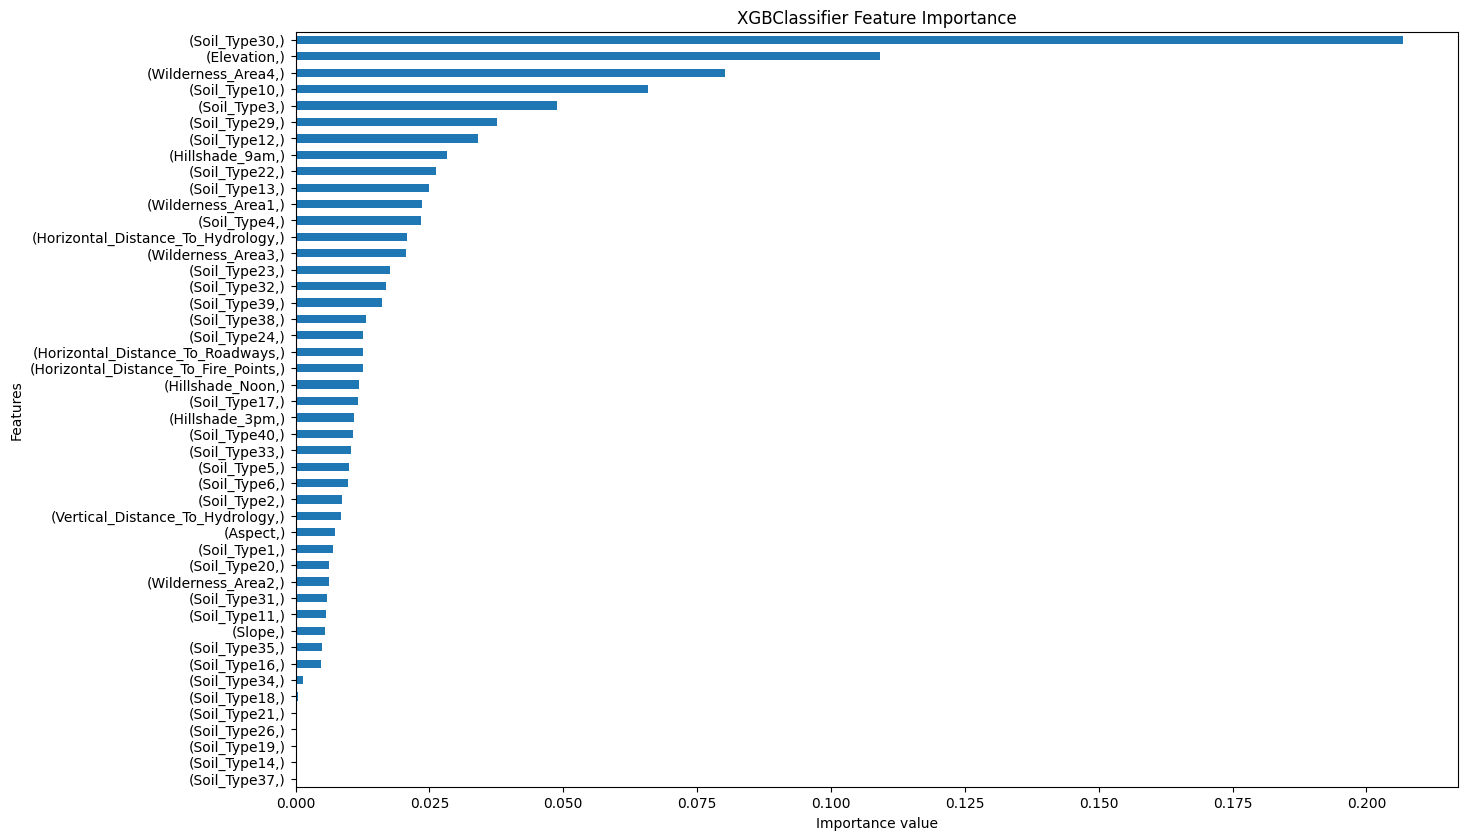

In [32]:
classsifier_name = clf_name(estimator=estimator, est_dict=est_dict)
importances = pd.Series(estimator.named_steps[classsifier_name.lower()].feature_importances_, feat_name).sort_values(ascending=True)
plt.figure(figsize=(15,10))
ax = importances.plot.barh()
ax.set_title(f"{classsifier_name} Feature Importance")
ax.set_ylabel("Features")
ax.set_xlabel("Importance value")

### Early stop over fitting

In [33]:
# XGBoost early stop fit
xform = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(),
)


xform.set_params(functiontransformer__kw_args = kwargs_dict)

X_train_xform = xform.fit_transform(X_train)
X_val_xform = xform.transform(X_val)
# X_test_xform = xform.transform(X_test)

model = XGBClassifier(
    n_estimators = 1000,
    max_depth=8,
    learning_rate=0.5,
    num_parallel_tree = 10,
    n_jobs=-1
)

#eval_set
eval_set = [(X_train_xform, y_train), (X_val_xform, y_val)]

model.fit(X_train_xform, y_train, 
          eval_set=eval_set, 
          eval_metric=['merror', 'mlogloss'], 
          early_stopping_rounds=50,
          verbose=False) # Stop if the score hasn't improved in 50 rounds

print('Training Accuracy:', model.score(X_train_xform, y_train))
print('Validation Accuracy:', model.score(X_val_xform, y_val))

y_pred = model.predict(X_val_xform)


Training Accuracy: 0.9988425925925926
Validation Accuracy: 0.8558201058201058


dict_keys(['validation_0', 'validation_1'])


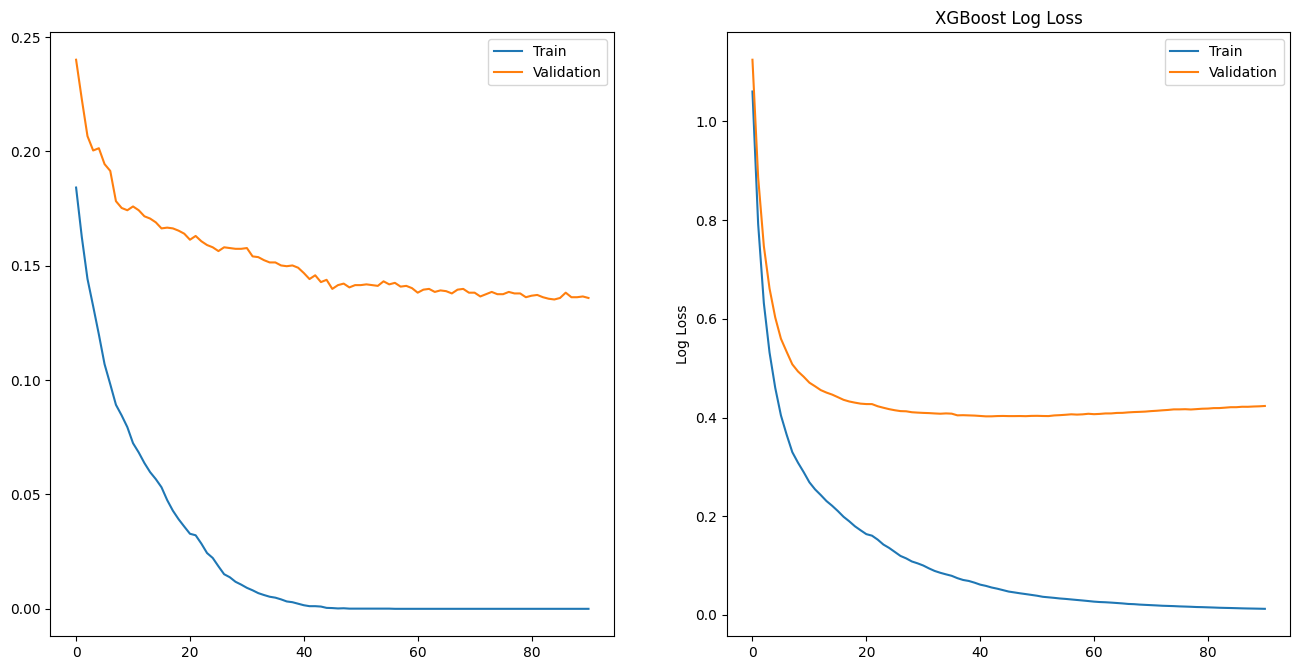

In [34]:
import matplotlib.pyplot as plt
# retrieve performance metrics
results = model.evals_result()
print(results.keys())

# number of successful rounds before early stop fitting
# 'validation_0' : training data, 'validation_1': val data
n_rounds = len(results['validation_1']["merror"])
x_axis = range(0, n_rounds)

# plot classification error
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

ax1.plot(x_axis, results['validation_0']['merror'], label='Train')
ax1.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax1.legend()
plt.ylabel('Classification MError')
plt.title('XGBoost Classification MError')

ax2.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax2.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax2.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')

plt.show()

### Cross Validation Curve: split the train set into train and validation for multiple folds

val scores [[0.71949405 0.72594246 0.72321429]
 [0.78819444 0.79042659 0.77876984]
 [0.79315476 0.80357143 0.79464286]
 [0.80233135 0.80679563 0.79365079]
 [0.80406746 0.80679563 0.80828373]
 [0.80753968 0.80753968 0.80332341]
 [0.79761905 0.80555556 0.79513889]
 [0.796875   0.80282738 0.79861111]
 [0.79662698 0.79563492 0.79365079]]
val scores mean [0.7228836  0.78579696 0.79712302 0.80092593 0.80638228 0.80613426
 0.79943783 0.79943783 0.79530423]


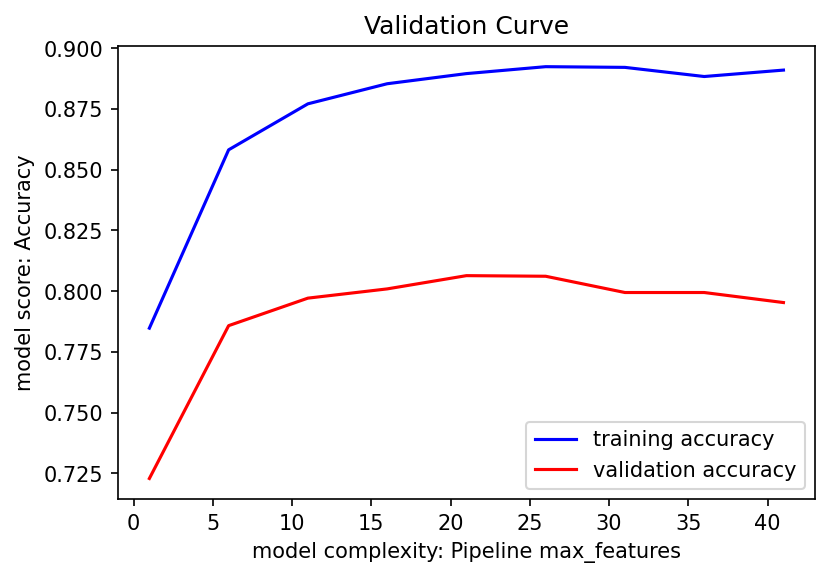

In [35]:
estimator=rfc
classifier_name = clf_name(estimator=estimator, est_dict=est_dict)

# # For FunctionTransformer
# par_name = "drop_count"
# param_range = [{par_name: i} for i in range(len(Id_skew_cols))]
# param_rangex = [i for i in range(len(Id_skew_cols))]

par_name = "max_features"
param_range = np.arange(1,len(feat_name[0]),5)
param_rangex = param_range
               
# par_name = "max_depth"
# param_range = range(1,25,1)
# param_rangex = param_range

# par_name = "min_samples_split"
# param_range = np.linspace(10, 0.01*len(X_train), 10, endpoint=True).astype(int)
# param_rangex = param_range

# par_name = "min_samples_leaf"
# param_range = np.linspace(2, 0.001*len(X_train), 10, endpoint=True).astype(int)
# param_rangex = param_range

# par_name = "criterion"
# param_range = ["gini", "entropy"]
# param_rangex = param_range

param_name=classifier_name.lower()+'__'+ par_name

estimator.set_params(functiontransformer__kw_args = kwargs_dict)

train_scores, val_scores = validation_curve(
    estimator, X_train, y_train,
    # param_name='functiontransformer__kw_args',
    param_name=param_name, 
    
    param_range=param_range, 
    scoring='accuracy', 
    cv=3,
    n_jobs=-1
)
print("val scores", val_scores)
print("val scores mean", np.mean(val_scores, axis=1))

# Averaging CV scores
plt.figure(dpi=150)
plt.plot(param_rangex, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(param_rangex, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve')
plt.xlabel(f'model complexity: Pipeline {par_name}')
plt.ylabel('model score: Accuracy')
plt.legend();

beyoun 30 features drop, validation accuracy starts going down.

### RandomizedSearchCV

In [36]:
# pipe = make_pipeline(FunctionTransformer(log_columns, ), PCA(), SVC())

# param_grid = dict(
#     functiontransformer__kw_args=[
#         {'col_idx': None},
#         {'col_idx': [1]}
#     ],
#     pca__n_components=[2, 5, 10],
#     svc__C=[0.1, 10, 100],
# )
# grid_search = GridSearchCV(pipe, param_grid=param_grid)

# digits = load_digits()
# res = grid_search.fit(digits.data, digits.target)      

### RandomizedSearchCV

In [37]:

x_n_iter = 10

param_distributions = {
    # 'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    #  'functiontransformer__kw_args': [{par_name: i} for i in range(int(0.5*len(Id_skew_cols)))],
    'randomforestclassifier__min_samples_leaf': [random.randint(1, 1000) for i in range(20)], 
    'randomforestclassifier__min_samples_split': [random.randint(2, 1000) for i in range(20)], 
    'randomforestclassifier__max_features': [random.randint(2, 54) for i in range(20)], 
    'randomforestclassifier__criterion': ["gini", "entropy"]
    }

rscv = RandomizedSearchCV(
    estimator, 
    param_distributions=param_distributions, 
    n_iter=x_n_iter, 
    cv=4, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

rscv.fit(X_train, y_train)

best_est = rscv.best_estimator_
print('Cross-validation Accuracy', rscv.best_score_)
print('Best hyperparameters', rscv.best_params_)
rscv.best_estimator_


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.8s finished


Cross-validation Accuracy 0.664103835978836
Best hyperparameters {'randomforestclassifier__min_samples_split': 262, 'randomforestclassifier__min_samples_leaf': 61, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'entropy'}


Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7fbabb42d950>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'cols': ['Id', 'Soil_Type15',
                                                       'Soil_Type7',
                                                       'Soil_Type25',
                                                       'Soil_Type8',
                                                       'Soil_Type28',
                                                       'Soil_Type9',
                                                       'Soil_Type36',
                                                       'Soil_Type27'],
                                              'drop_count': 9},
                                     validate=False)),
                (...
  

In [38]:
best_feat = best_est.named_steps['functiontransformer'].transform(X_train).columns
best_feat, best_feat.shape

(Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
        'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
        'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
        'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
        'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
        'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type26',
        'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
        'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type37',
        'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
       dtype='object'), (46,))

In [39]:
#.predict: WITHOUT ACTUALLY TRANSFORMING X, APPLIES THE TRANSFORMS TO X AND PREDICT a fitted y
# wrangle_col = pipeline.named_steps['functiontransformer'].transform(X_train).columns


print(f' X_val shape before predict : {X_val.shape}')
print("predicting ...")
y_pred = best_est.predict(X_val)
print(f' X_val shape after predict : {X_val.shape}')
print('Validation Accuracy', accuracy_score(y_val, y_pred))

 X_val shape before predict : (3024, 55)
predicting ...
 X_val shape after predict : (3024, 55)
Validation Accuracy 0.6802248677248677
